In [1]:
# Cell 1 ‑‑‑ imports and cube loading
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from astropy.io import fits
from astropy import units as u
from astropy import constants as c

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

In [2]:


# --------- file location (edit if needed) ----------
cube_path = Path("IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits")
print("Loading:", cube_path.resolve())

with fits.open(cube_path) as hdul:
    data = hdul["DATA"].data.astype(np.float32)   # (nz, ny, nx)
    stat = hdul["STAT"].data.astype(np.float32)
    dq   = hdul["DQ"].data.astype(np.uint8)
    hdr  = hdul["DATA"].header

nz, ny, nx = data.shape
print(f"Cube dimensions  →  nz = {nz},  ny = {ny},  nx = {nx}")
hdr
hdul.close()


Loading: /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits
Cube dimensions  →  nz = 3761,  ny = 438,  nx = 437


In [3]:
# Cell 2  –– wavelength array (Å), λ‑cut, velocity scale
from astropy.wcs import WCS

# --- 2.1 build wavelength array in Å ---
wcs_3d = WCS(hdr)                       # 3‑D WCS (RA, Dec, λ)
spec_pix = np.arange(nz)                # spectral pixel indices (0 … nz‑1)
lam_min = 4750.0                     # min λ in Å,
lam_max = 7000.0                     # max λ in Å. 

# all_pix2world returns metres for the spectral axis in this cube → convert to Å
lam_m  = wcs_3d.all_pix2world(
             np.zeros_like(spec_pix),   # dummy RA
             np.zeros_like(spec_pix),   # dummy Dec
             spec_pix,                  # spectral pixel
             0)[2]                      # wavelength [m]
lam_ang = lam_m * 1e10                  # metres → Å

# --- 2.2 keep only λ < 7000 Å ---
cut = (lam_ang >= lam_min) & (lam_ang <= lam_max)
lam_ang = lam_ang[cut]
data    = data[cut, :, :]
stat    = stat[cut, :, :]
dq      = dq[cut,   :, :]
nz      = lam_ang.size                 # update nz after trimming
print(f"After λ‑cut (<=7000 Å)  →  nz = {nz}")

# --- 2.3 compute velocity scale (km s⁻¹ per pixel) ---
c_kms   = c.c.to(u.km/u.s).value        # 299 792.458
dlnλ    = np.diff(np.log(lam_ang))  # dlnλ in Å
velscale = np.min(c_kms * dlnλ) # km/s per pixel
print(f"Velocity scale (min)  →  velscale = {velscale:.2f} km/s")


After λ‑cut (<=7000 Å)  →  nz = 1800
Velocity scale (min)  →  velscale = 53.55 km/s


Integrated spectrum built:
   simple‑sum shape    : (1800,)


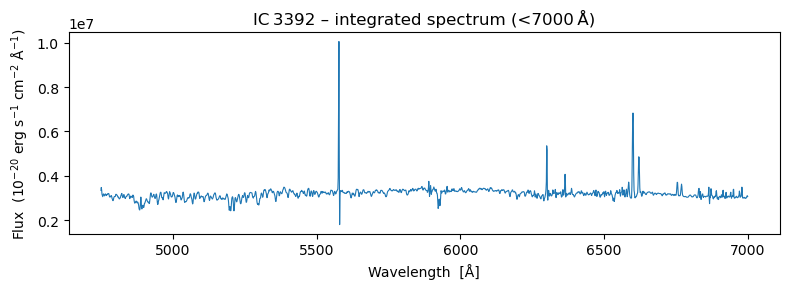

In [4]:
# Cell 3 –– integrate cube to 1‑D spectrum + noise  (v2: NaN‑safe)
# ----------------------------------------------------------------

# ---- 3.1 simple‑sum spectrum ----
flux_sum  = np.nansum(data, axis=(1, 2))          # erg s⁻¹ cm⁻² Å⁻¹
# flux_sum = flux_sum / np.nanmedian(flux_sum)  # normalize to median
noise_wgt = np.sqrt(np.nansum(stat, axis=(1, 2)))  # shape = (nz,)

print("Integrated spectrum built:")
print(f"   simple‑sum shape    : {flux_sum.shape}")

# ---- 3.2 quick plot ----
plt.figure(figsize=(8, 3))
plt.plot(lam_ang, flux_sum, lw=0.8)
plt.xlabel("Wavelength  [Å]")
plt.ylabel(r"Flux  ($10^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)")
plt.title("IC 3392 – integrated spectrum (<7000 Å)")
plt.tight_layout();  plt.show()

# # ---- 3.3 normalized the flux to be near unity ----
# # normalize to the median of the spectrum
# # normalisation = np.nanmedian(flux_sum)
# normalisation = 1
# flux_sum /= normalisation
# noise_wgt /= normalisation
# print("Integrated spectrum normalised:")
# print("Normalisation factor:", normalisation)

# # ---- 3.4 normalized plot ----
# plt.figure(figsize=(8, 3))
# plt.plot(lam_ang, flux_sum, lw=0.8)
# plt.xlabel("Wavelength  [Å]")
# plt.ylabel("Normalized flux")
# plt.title("IC 3392 – integrated spectrum (<7000 Å)")
# plt.tight_layout();  plt.show()

Hα‑based red‑shift  z = 0.00567   (v ≈ 1699.3 km/s)
Masked wavelength bins : 328 of 1800 (18.2 %)


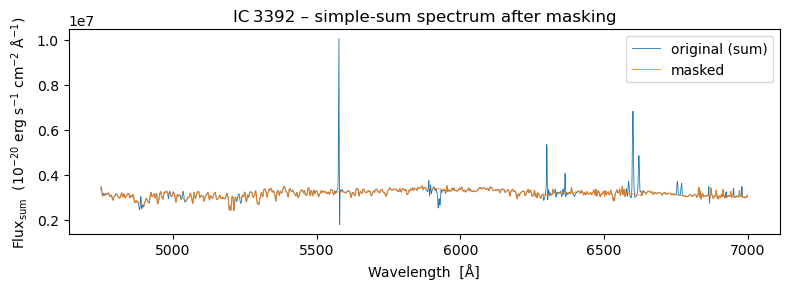

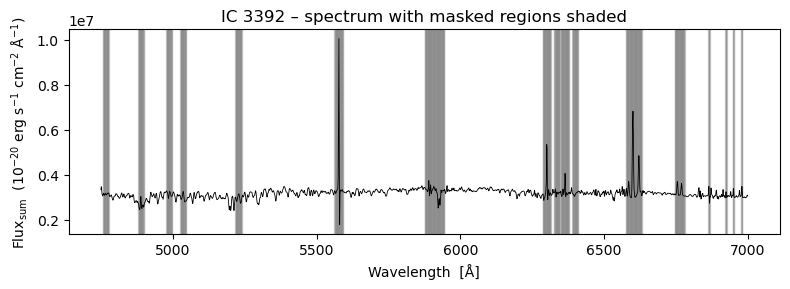

In [5]:
# Cell 4 –– red‑shift guess & dual‑spectra masking (sky ≠ red‑shifted)
# -------------------------------------------------------------------
import numpy as np

# -- 4.1  red‑shift from Hα using the simple‑sum spectrum --------------
h_alpha_lab = 6562.8
win = (lam_ang > 6500) & (lam_ang < 6700)
lam_peak = lam_ang[win][np.nanargmax(flux_sum[win])]
z_guess  = lam_peak / h_alpha_lab - 1
v_guess  = z_guess * c_kms
print(f"Hα‑based red‑shift  z = {z_guess:.5f}   (v ≈ {v_guess:.1f} km/s)")

# -- 4.2  read mask table ------------------------------------------------
mask_dtype = [('lam', 'f8'), ('width', 'f8'), ('comment', 'U32')]
mask_tbl  = np.genfromtxt("specMask_KIN.txt", dtype=mask_dtype,
                          comments='#', usecols=(0,1,2), encoding=None)

# -- 4.3  construct bad‑pixel mask --------------------------------------
mask_bad = np.zeros_like(lam_ang, dtype=bool)

for lam_rest, width_rest, comment in mask_tbl:
    # sky lines: use rest value directly (no z shift)
    if comment.strip().lower() == 'sky':
        lam_obs   = lam_rest
        width_obs = width_rest
    else:                       # nebular/emission lines → red‑shifted
        lam_obs   = lam_rest  * (1 + z_guess)
        width_obs = width_rest * (1 + z_guess)

    m = (lam_ang > lam_obs - width_obs/2) & (lam_ang < lam_obs + width_obs/2)
    mask_bad |= m

print(f"Masked wavelength bins : {mask_bad.sum()} of {lam_ang.size} "
      f"({100*mask_bad.mean():.1f} %)")

# --- 4.4 replace masked pixels with local mean along the wavelength axis ---

def fill_bad_1d(spec, bad):
    """
    spec : 1‑D array  (your flux vector)
    bad  : 1‑D bool   (True where you want to replace)
    Returns a *new* array with bad entries replaced by the
    mean of the nearest good pixels on either side.
    """
    filled = spec.copy()

    if bad.any():
        good = ~bad
        # np.interp does linear interpolation; for a single pixel gap
        # that is exactly the mean of its two neighbours
        filled[bad] = np.interp(np.flatnonzero(bad),         # x  to fill
                                np.flatnonzero(good),        # x of neighbours
                                spec[good])                  # y of neighbours
    return filled

# 1‑D masks (length = nz)
bad_1d = mask_bad.copy()

flux_sum_masked = fill_bad_1d(flux_sum, bad_1d)

# keep the noise = ∞ so pPXF still gives zero weight there
noise_wgt_masked = noise_wgt.copy()
noise_wgt_masked[bad_1d] = np.inf

# -- 4.5  quick visual check -----------------------
plt.figure(figsize=(8,3))
plt.plot(lam_ang, flux_sum,        lw=0.6, label='original (sum)')
plt.plot(lam_ang, flux_sum_masked, lw=0.8, label='masked', alpha=0.8)
plt.xlabel('Wavelength  [Å]')
plt.ylabel(r'Flux$_\mathrm{sum}$  (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
plt.title('IC 3392 – simple‑sum spectrum after masking')
plt.legend();  plt.tight_layout();  plt.show()

# Extract the region that we maks out
lam_ang_masked = lam_ang[bad_1d]
flux_sum_masked = flux_sum_masked[bad_1d]

# ---- outputs for Cell 5 ----
# lam_ang, flux_wgt_masked, noise_wgt_masked, flux_sum_masked

# after building mask_bad:
lam_remove = lam_ang[mask_bad]
lam_good   = lam_ang[~mask_bad]
# Plot the spectrum with the reomve regions with vertical gray shading 
plt.figure(figsize=(8, 3))
plt.plot(lam_ang, flux_sum, lw=0.6, color = 'black', label='original (sum)')
# shade out the removed wavelength bins
half_bin = np.diff(lam_ang).mean() / 2
for lam in lam_remove:
    plt.axvspan(lam - half_bin, lam + half_bin, color='gray', alpha=0.3)

plt.xlabel('Wavelength  [Å]')
plt.ylabel(r'Flux$_\mathrm{sum}$  (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
plt.title('IC 3392 – spectrum with masked regions shaded')
plt.tight_layout()
plt.show()

In [6]:
# Cell 5 –– log‑rebinning the chosen 1‑D spectrum
# -----------------------------------------------
from ppxf import ppxf_util

# ----- 5.0  get spectrum -----

flux_1d_raw  = flux_sum
noise_1d_raw = noise_wgt

#  rebin flux & noise *with* the measured velscale_out
log_flux, log_lam, _ = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], flux_1d_raw,
    velscale=velscale, flux=True)

log_noise, _, _ = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], noise_1d_raw,
    velscale=velscale, flux=False)

print(f"Log‑grid length : {log_flux.size} pixels")
print(f"velscale        : {velscale:.3f} km/s")


Log‑grid length : 2171 pixels
velscale        : 53.549 km/s


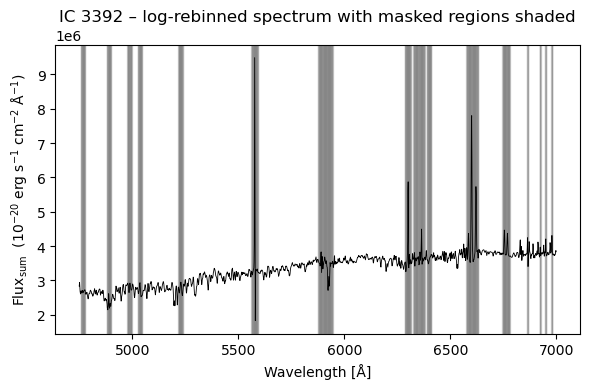

In [7]:
plt.figure(figsize=(6,4))
lam_plot = np.exp(log_lam)
plt.plot(lam_plot, log_flux, 'k-', lw=0.6)
half_bin = np.diff(lam_plot).mean() / 2
for lam in lam_remove:
    plt.axvspan(lam - half_bin, lam + half_bin, color='gray', alpha=0.3)
plt.xlabel('Wavelength [Å]')
plt.ylabel(r'Flux$_\mathrm{sum}$  (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
plt.title('IC 3392 – log‐rebinned spectrum with masked regions shaded')
plt.tight_layout()
plt.show()


In [8]:
# Setup SPS templates

# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

FWHM_gal = None   # set this to None to skip templates broadening
print("Loading E‑MILES SSP grid …")
# sps = lib.sps_lib(filename, velscale_out, fwhm_gal=None,
#                   norm_range=[lam_min, 7000]
#                   )    

# linspace the wavelength range
lam_temp_arr = np.linspace(4e3, 1e4, 100000)
# lam_temp_arr = np.arange(4e3, 1e4+1, 1e4)
 
# Define the FWHM of the galaxy templates
# Using Emsellem+2022 for MUSE LSF
fwhm_gal = {
    "lam": lam_temp_arr,
    "fwhm": 5.866e-8 * lam_temp_arr**2 
            - 9.187e-4 * lam_temp_arr 
            + 6.040
}

sps = lib.sps_lib(
    filename, velscale, fwhm_gal,
    norm_range=[lam_min, lam_max],
    lam_range=[4e3, 1e4],
)

# sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar

templates_hr = sps.templates          # (n_wave, n_age, n_Z)
lam_temp_hr  = sps.lam_temp           # length 18 998 Å

print(f"Template wavelength range: {sps.lam_temp[0]:.1f} to {sps.lam_temp[-1]:.1f} Å")

Loading E‑MILES SSP grid …
Template wavelength range: 4000.7 to 9998.4 Å


In [9]:
fwhm_gal

{'lam': array([ 4000.       ,  4000.0600006,  4000.1200012, ...,  9999.8799988,
         9999.9399994, 10000.       ], shape=(100000,)),
 'fwhm': array([3.30376   , 3.30373303, 3.30370607, ..., 2.71896946, 2.71898473,
        2.719     ], shape=(100000,))}

 Best Fit:       Vel     sigma
 comp.  0:      1676        66
Attenuation Parameters 0: 1.586 0.000
chi2/DOF: 750.2; DOF: 1774; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/150
V = 1675.514 km/s,  σ = 65.720 km/s


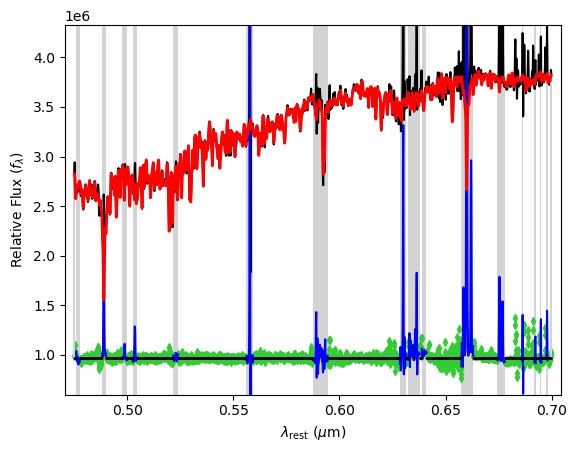

In [10]:
reg_dim = sps.templates.shape[1:]
stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)
regul_err = 0.01  # Large regularization error

# Compute which rebinned pixels fall on unmasked (good) λ
lam_grid = np.exp(log_lam)                   # rebinned wavelengths in Å
pix      = np.searchsorted(lam_ang, lam_grid)
goodpixels = np.where(~mask_bad[pix])[0]


# Boolean mask telling pPXF which templates see this dust
n_temp         = stars_templates.shape[1]           # total columns
stars_component = np.ones(n_temp, dtype=bool)       # all templates = stars
# If you later append gas templates, set stars_component[:n_star] = True,
#                                                stars_component[n_star:] = False

# 2.  Define the dust dictionary (A_V  and  δ ≡ tilt of the curve)
dust_stars = {
    "start"    : [1., 0],      # initial A_V (mag) and δ
    "bounds"   : [
                  [0.0, 4.0],      # A_V ∈ [0, 4]
                #   [-1.5, 0.4],    # δ   ∈ [–1, 0.4]  (Calzetti-like tilt)
                             ],   
    "component": stars_component,  # Boolean mask defined above
    # "func"   : my_custom_curve   # only if you want your own law
}
dust = [dust_stars]

# Run pPXF only on those good pixels
from ppxf import ppxf

start_V   = v_guess
start_sig = 5 * velscale

pp = ppxf.ppxf(
    # templates   = sps.templates,
    templates   = stars_templates,
    galaxy      = log_flux,
    noise       = log_noise,
    velscale    = velscale,
    start       = [start_V, start_sig],
    degree      = 12,
    mdegree     = 0,
    moments     = 2,
    # trig        = 1, 
    # clean       = True,
    goodpixels  = goodpixels,
    lam         = np.e**(log_lam),
    lam_temp    = sps.lam_temp, 
    regul       = 0, 
    reg_dim     = reg_dim,
    dust        = dust,
    plot        = True, 
    quiet       = False)

print(f"V = {pp.sol[0]:.3f} km/s,  σ = {pp.sol[1]:.3f} km/s")

In [11]:
z_fit = pp.sol[0] / c_kms
print(f"Fitted redshift  : {z_fit:.5f}")
print(f"Compared to guess redshift  : {z_guess:.5f}  (Hα)")
# # ---------- Composite M/L from pPXF weights ------------------------
weights = pp.weights.reshape(reg_dim)  / pp.weights.sum()    
ML_r = sps.mass_to_light(weights, band="SDSS/r", redshift=z_fit,)                     # intrinsic M/L (dimensionless)
print(f"M/L (r band)  : {ML_r:.3f}  M☉/L☉ = log({np.log10(ML_r):.3f}  M☉/L☉)")

Fitted redshift  : 0.00559
Compared to guess redshift  : 0.00567  (Hα)
(M*/L)=2.329 (SDSS/r at z=0.0056)
M/L (r band)  : 2.329  M☉/L☉ = log(0.367  M☉/L☉)


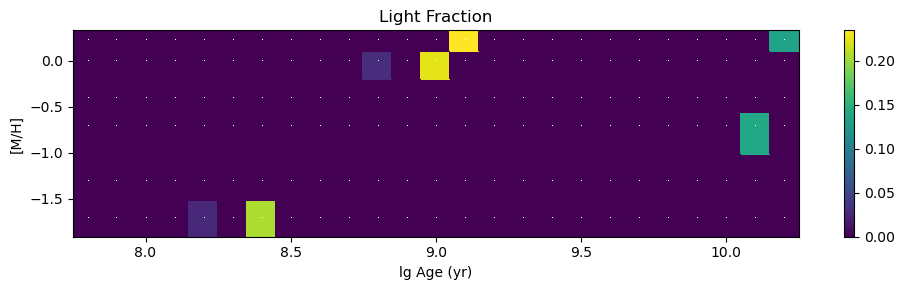

In [12]:
plt.figure(figsize=(10,3))
sps.plot(weights)
plt.title("Light Fraction")
plt.tight_layout()
plt.show()